In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
import os
import re

In [3]:
def prepare_stromfluesse(path_to_data_storage):
    
    dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
    numberparse = lambda x: pd.np.float(x.replace(".", "").replace(",",".")) if x!="-" else np.nan
    convert_thousand = { num:numberparse   for num in np.arange(2,22)}
    
    import_files = os.listdir(path_to_data_storage)

    for idx , file in enumerate(import_files):
        print("Import File: {} ".format(file))
        PATH = path_to_data_storage + file
        if idx>0:
            df2 = pd.read_csv(PATH,
                sep=r";",
                decimal=r",",
                thousands=r".",
                converters = convert_thousand,
                parse_dates=['Datum'],
                date_parser = dateparse )
            df = df.append(df2)
        else:
            df = pd.read_csv(PATH,
                sep=r";",
                decimal=r",",
                thousands=r".",
                converters = convert_thousand,
                parse_dates=['Datum'],
                date_parser = dateparse)
    
    df['Date'] = df.apply(lambda row: _create_datetime(row), axis=1) 
    df['Date'] = pd.to_datetime(df.Date,format="%Y-%m-%d %H:%M")
    df = df.sort_values('Date').reset_index(drop=True)

    cols = list(df)
    cols.insert(0, cols.pop(cols.index('Date')))
    df = df.loc[:, cols]
    df.drop(['Uhrzeit'],axis=1,inplace=True)
    
    type_pattern = r"\((.*?)\)"
    country_pattern = r"(.*?) "
    countries = {
    'Niederlande':'NL',
    'Schweiz': 'CHE',
    'Dänemark' : 'DNK',
    'Tschechien' : 'CZE',
    'Luxemburg' : 'LUX',
    'Schweden' : 'SWE',
    'Österreich' : 'AUT',
    'Frankreich' : 'FRA',
    'Polen' : 'PL'
    } 

    types = {
        'Import' : 'IM',
        'Export' : 'EX'
    }

    new_columns = [countries.get(re.search(country_pattern,col).group(1)) + 
     "_" + 
     types.get(re.search(type_pattern,col).group(1))
     for col in df.columns[3::]]
    new_columns.insert(0,'Date')
    new_columns.insert(1,'Tag')
    new_columns.insert(2,'NX')
    df.columns = new_columns
    
    df['NX'] = df.loc[:, 'NL_EX':'PL_IM'].sum(axis=1)
    
    df = df.fillna(0)
    
    for key,value in countries.items():
        expo = value + "_EX"
        impo = value + "_IM"
        df[value] = df[expo] + df[impo]
        df.drop([expo,impo],axis=1,inplace=True)

    return df

def _create_datetime(row):
    date = row.Datum.strftime("%Y-%m-%d") + " " + row.Uhrzeit
    return date

def prepare_strompreise(path_to_data_storage, aggregate=True):

    dateparse = lambda x: pd.datetime.strptime(x, "%d.%m.%Y")
    numberparse = (
        lambda x: pd.np.float(x.replace(".", "").replace(",", "."))
        if x != "-"
        else np.nan
    )
    convert_thousand = {num: numberparse for num in np.arange(2, 22)}

    import_files = os.listdir(path_to_data_storage)

    for idx, file in enumerate(import_files):
        print("Import File: {} ".format(file))
        PATH = path_to_data_storage + file
        if idx > 0:
            df2 = pd.read_csv(
                PATH,
                sep=r";",
                decimal=r",",
                thousands=r".",
                converters=convert_thousand,
                parse_dates=["Datum"],
                date_parser=dateparse,
            )
            df_price = df_price.append(df2)
        else:
            df_price = pd.read_csv(
                PATH,
                sep=r";",
                decimal=r",",
                thousands=r".",
                converters=convert_thousand,
                parse_dates=["Datum"],
                date_parser=dateparse,
            )

    df_price["Date"] = df_price.apply(lambda row: _create_datetime(row), axis=1)
    df_price["Date"] = pd.to_datetime(df_price.Date, format="%Y-%m-%d %H:%M")
    df_price = df_price.sort_values("Date").reset_index(drop=True)

    cols = list(df_price)
    cols.insert(0, cols.pop(cols.index("Date")))
    df_price = df_price.loc[:, cols]
    df_price.drop(["Uhrzeit"], axis=1, inplace=True)

    delete_currency = r"(.*?)\["
    new_columns = [
        "price_" + re.search(delete_currency, col).group(1).lower()
        for col in df_price.columns[2::]
    ]
    new_columns.insert(0, "Date")
    new_columns.insert(1, "Tag")
    df_price.columns = new_columns

    df_price.fillna(df_price.mean(), inplace=True)

    df_price_aggregated = pd.DataFrame(columns=df_price.columns[2::])

    ind = 0
    for name, df in df_price.groupby("Tag"):
        mean_price_day = df.iloc[:, 2::].mean()
        df_price_aggregated = df_price_aggregated.append(
            mean_price_day, ignore_index=True
        )

    df_price_aggregated.columns = [
        "daily_" + col for col in df_price_aggregated.columns
    ]

    df_price_aggregated["Tag"] = df_price.Tag.unique()

    cols = list(df_price_aggregated)
    cols.insert(0, cols.pop(cols.index("Tag")))
    df_price_aggregated = df_price_aggregated.loc[:, cols]

    if aggregate == True:
        return df_price_aggregated
    else:
        return df_price
    


In [7]:
df = prepare_stromfluesse("../../data/stromfluss/")
df.head()

Import File: DE_Physikalischer_Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer_Stromfluss_201706020000_201906022359_1.csv 


,Date,Tag,NX,NL,CHE,DNK,CZE,LUX,SWE,AUT,FRA,PL
0,2015-06-01 00:00:00,2015-06-01,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,1394.0,246.0,1279.0
1,2015-06-01 01:00:00,2015-06-01,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,1355.0,66.0,1142.0
2,2015-06-01 02:00:00,2015-06-01,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,1574.0,-105.0,1134.0
3,2015-06-01 03:00:00,2015-06-01,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,1271.0,-206.0,1090.0
4,2015-06-01 04:00:00,2015-06-01,5347.0,4292.0,-127.0,-582.0,161.0,0.0,1.0,1068.0,-549.0,1083.0


In [9]:
# Spalten hinzufügen
# Wochentag, Monat, Jahr, Zeitpunkt als Sekundenstempel
# Lagging: Alle Datenpunkte aus dem Punkt davor
# 
def split_datetime(df):
    date_key = df.select_dtypes(include=[np.datetime64]).columns[0]
    df['year']=df[date_key].apply(lambda x: x.year)
    df['month']=df[date_key].apply(lambda x: x.month)
    df['weekday']=df[date_key].apply(lambda x: x.isoweekday())
    df['timestamp']=df[date_key].apply(lambda x:(x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
    df['hour'] = df[date_key].apply(lambda x: x.hour)
    df = df.drop(columns=[date_key])
    return df

def merge_datetime(df):
    df['Date']=df['timestamp'].apply(lambda x: (x * np.timedelta64(1,'s') + np.datetime64('1970-01-01T00:00:00Z')))
    df = df.drop(columns = ["year","month","weekday", "timestamp", "hour"])
    return df

df2 = split_datetime(df)


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # Remove the CWD from sys.path while we load stuff.


In [44]:
X = df2[['year','month', 'weekday', 'hour', 'timestamp']]
y = df2['NX']
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [47]:
testing = df.iloc[-24:]
prediction = regr.predict(testing[['year','month', 'weekday', 'hour', 'timestamp']])

array([4456.78051512, 4456.78051512, 4456.78051512, 4456.78051512,
       4456.78051512, 4456.78051512, 4456.78051512, 4456.78051512,
       4456.78051512, 4456.78051512, 4521.2671581 , 4521.2671581 ,
       4521.2671581 , 4521.2671581 , 4521.2671581 , 4521.2671581 ,
       4521.2671581 , 4379.46522531, 3761.23907853, 3674.22331984,
       3674.22331984, 3674.22331984, 3674.22331984, 3674.22331984])

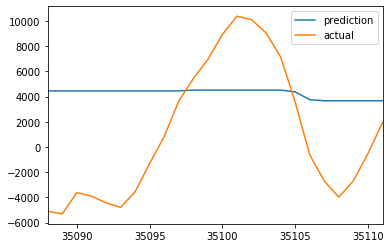

In [49]:
df_result = pd.DataFrame({"prediction":prediction, "actual":df.iloc[-24:]['NX']})
df_result.plot()

In [34]:
print(regr.score(X=df2.iloc[-1000:][['year','month','weekday','hour','timestamp']], y=df2.iloc[-1000:]['NX']))

0.06483614379668512
